Notebook to figure out how to get meaningful covariance measurements.

Solution: normalizing the train_y targets to within [-1, 1] so that the
GP has a better estimate of the prediction. If train_y are very small,
GP seems to treat it as noise.

In [ ]:
import math
import torch
import sys
if sys.platform == "win32":
    sys.path.insert(
        0,
        "C:\\Users\\twilkeni\\AppData\\Local\\anaconda3\\envs\\pytorch-env\\site-packages",
    )
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

In [20]:
bounds = np.array([[0,1]])
train_x = torch.linspace(bounds[0,0], bounds[0,1], 200)
amp = 0.04
var = amp/10
noise = torch.randn_like(train_x)*var
train_y = amp*np.sin(60 * train_x ** 4) + noise
# normalize the target values to [-1 1]
max_y = max(abs(train_y))
train_y = train_y/max_y
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

print("Initialized with: lengthscale=%.3f variance=%.3f noise=%.5f" % (model.covar_module.base_kernel.lengthscale.item(),
        model.covar_module.outputscale.item(),
        model.likelihood.noise.item()))

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 150
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f, variance: %.3f,   noise: %.5f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.covar_module.outputscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Initialized with: lengthscale=0.693 variance=0.693 noise=0.69325
Iter 1/150 - Loss: 0.935   lengthscale: 0.693, variance: 0.693,   noise: 0.69325
Iter 2/150 - Loss: 0.912   lengthscale: 0.644, variance: 0.644,   noise: 0.64450
Iter 3/150 - Loss: 0.888   lengthscale: 0.599, variance: 0.598,   noise: 0.59826
Iter 4/150 - Loss: 0.865   lengthscale: 0.556, variance: 0.554,   noise: 0.55453
Iter 5/150 - Loss: 0.843   lengthscale: 0.515, variance: 0.513,   noise: 0.51331
Iter 6/150 - Loss: 0.821   lengthscale: 0.477, variance: 0.474,   noise: 0.47457
Iter 7/150 - Loss: 0.801   lengthscale: 0.440, variance: 0.438,   noise: 0.43831
Iter 8/150 - Loss: 0.781   lengthscale: 0.407, variance: 0.404,   noise: 0.40447
Iter 9/150 - Loss: 0.763   lengthscale: 0.375, variance: 0.373,   noise: 0.37304
Iter 10/150 - Loss: 0.746   lengthscale: 0.345, variance: 0.344,   noise: 0.34396
Iter 11/150 - Loss: 0.730   lengthscale: 0.317, variance: 0.319,   noise: 0.31719
Iter 12/150 - Loss: 0.716   lengthscale: 0

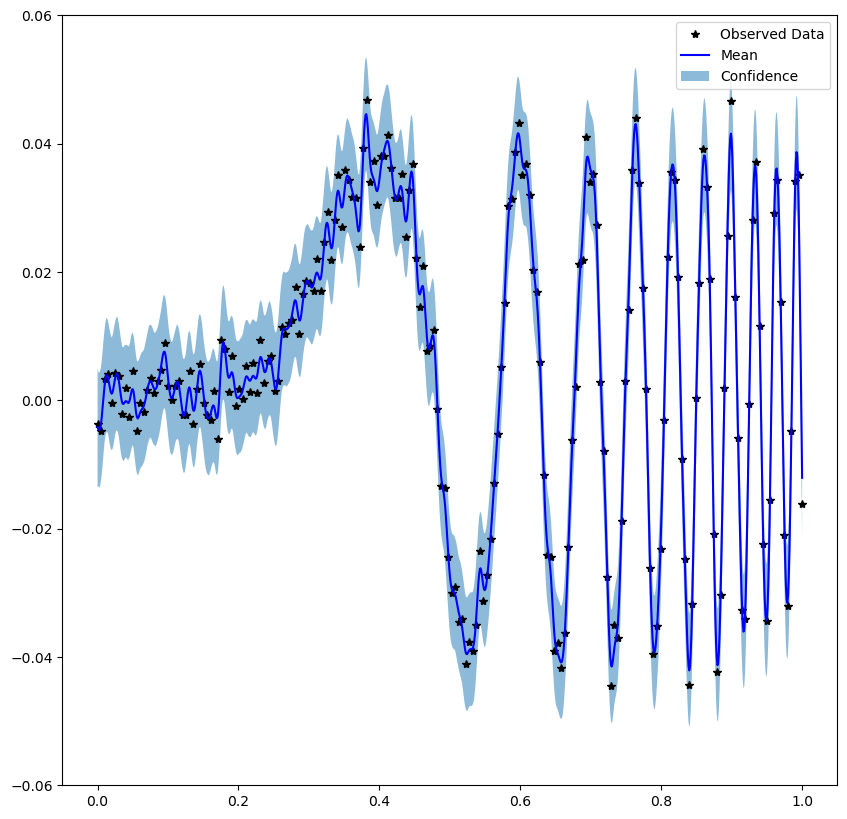

In [21]:
# Prediction
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(bounds[0,0], bounds[0,1], 1000)
    observed_pred = likelihood(model(test_x))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy()*max_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy()*max_y.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy()*max_y.numpy(), upper.numpy()*max_y.numpy(), alpha=0.5)
    ax.set_ylim([-amp*1.5, amp*1.5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])